In [1]:
import torch
from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0")

In [2]:
import os
import csv
from PIL import Image
from datasets import CernDataset, CernDatasetMassive

In [3]:
train_folder = 'C:/Users/Николай/Desktop/CernProject/data'
dataset = CernDatasetMassive(train_folder)

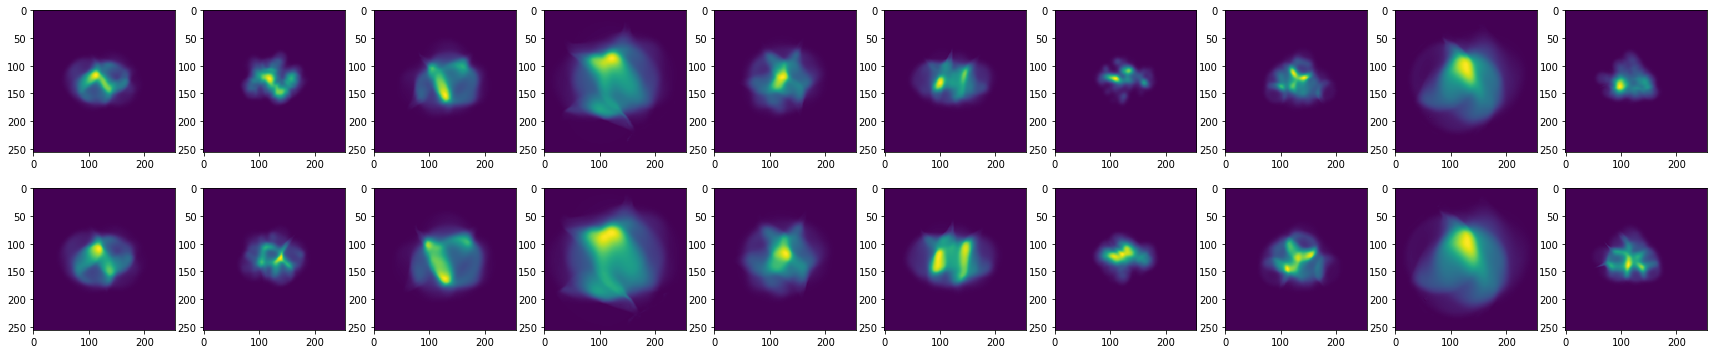

In [4]:
from visualisation import visualize_dataset

visualize_dataset(dataset, count=10, visualize_y=True)

In [6]:
batch_size = 1

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            loss_accum += loss_value.item()

        ave_loss = loss_accum / i_step
        val_loss = compute_loss(model, val_loader)
        
        loss_history.append(float(ave_loss))
        val_history.append(float(val_loss))
        
        if lr_scheduler:
            lr_scheduler.step()
        
        print("Average loss: %f, Val loss: %f" % (ave_loss, val_loss))
        
    return loss_history, val_history
        
def compute_loss(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        loss_value = loss(prediction, y_gpu)
        loss_accum += loss_value.item()

    ave_loss = loss_accum / i_step
    return ave_loss

In [8]:
from model import Unet
import torch.optim as optim

def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss
        
model = Unet(hidden_size=64)

#model.type(torch.cuda.DoubleTensor)
model.to(device)

loss = unet_loss
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
loss_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.114784, Val loss: 0.125116
Average loss: 0.086663, Val loss: 0.081510
Average loss: 0.082423, Val loss: 0.077414
Average loss: 0.080805, Val loss: 0.083223
Average loss: 0.079446, Val loss: 0.078241


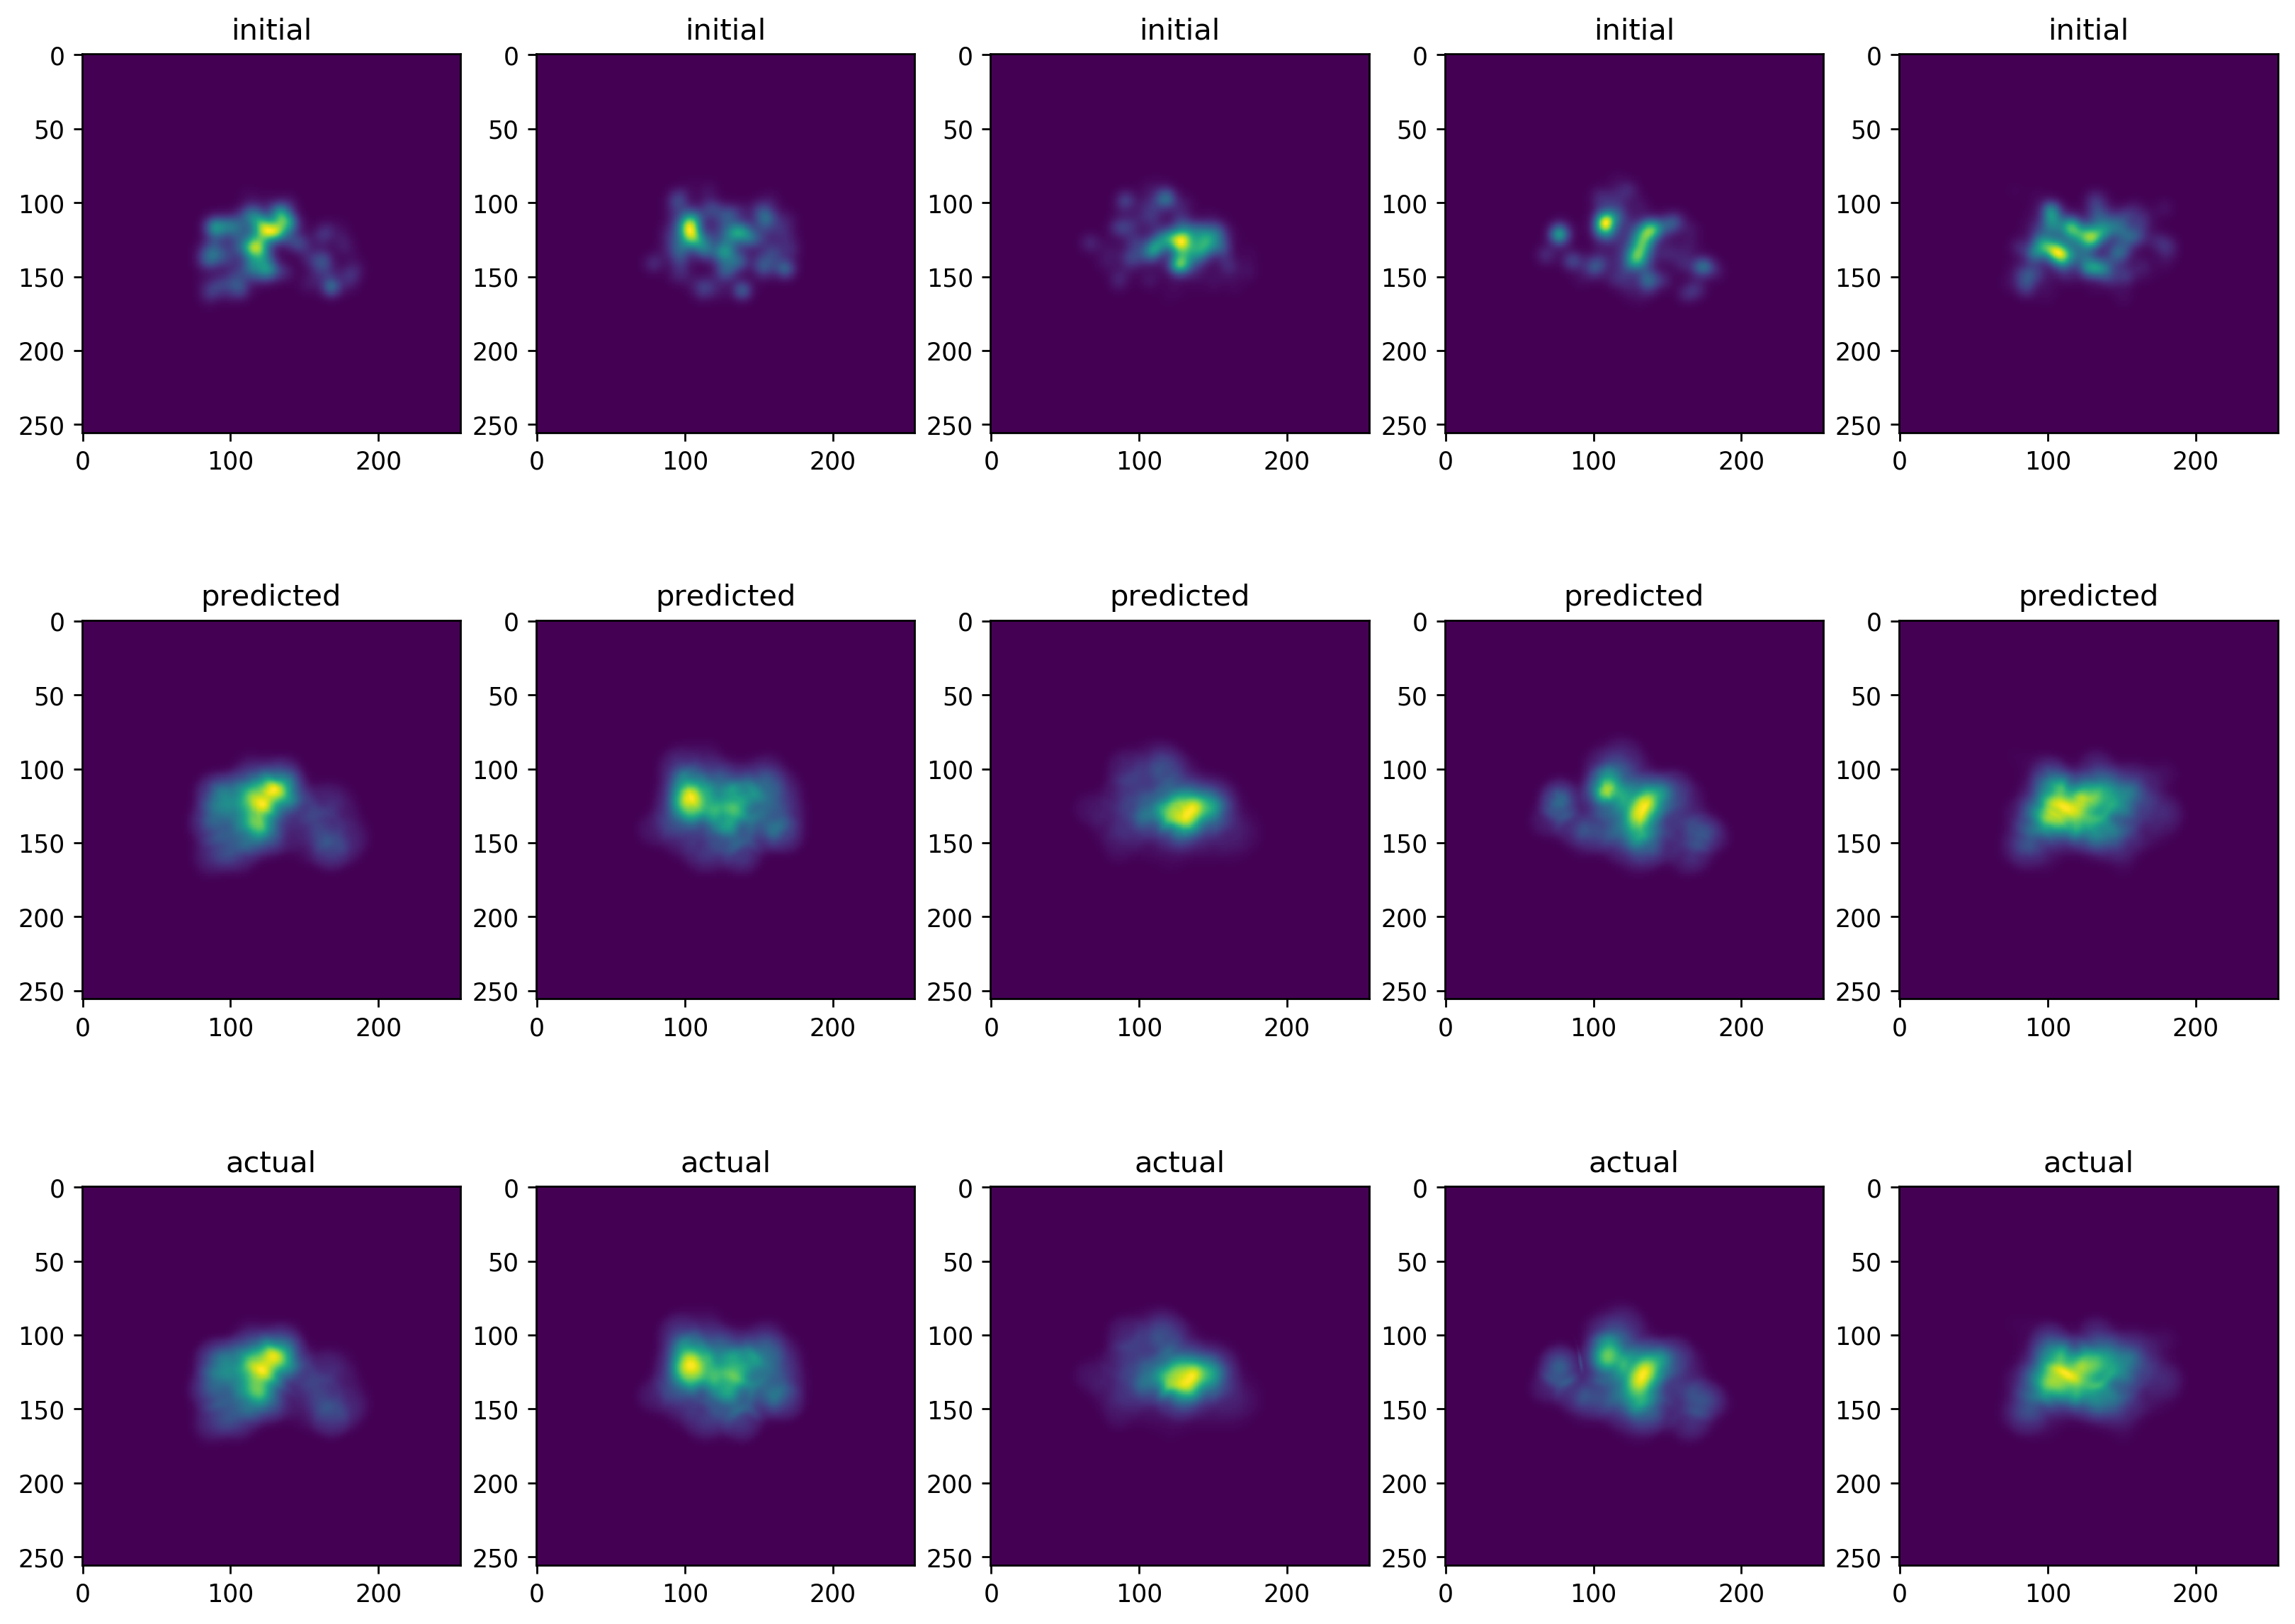

In [27]:
from visualisation import visualise_single_step_prediction
visualise_single_step_prediction(model, dataset)

In [5]:
model = torch.load('../models/model_massive_dset.pth')

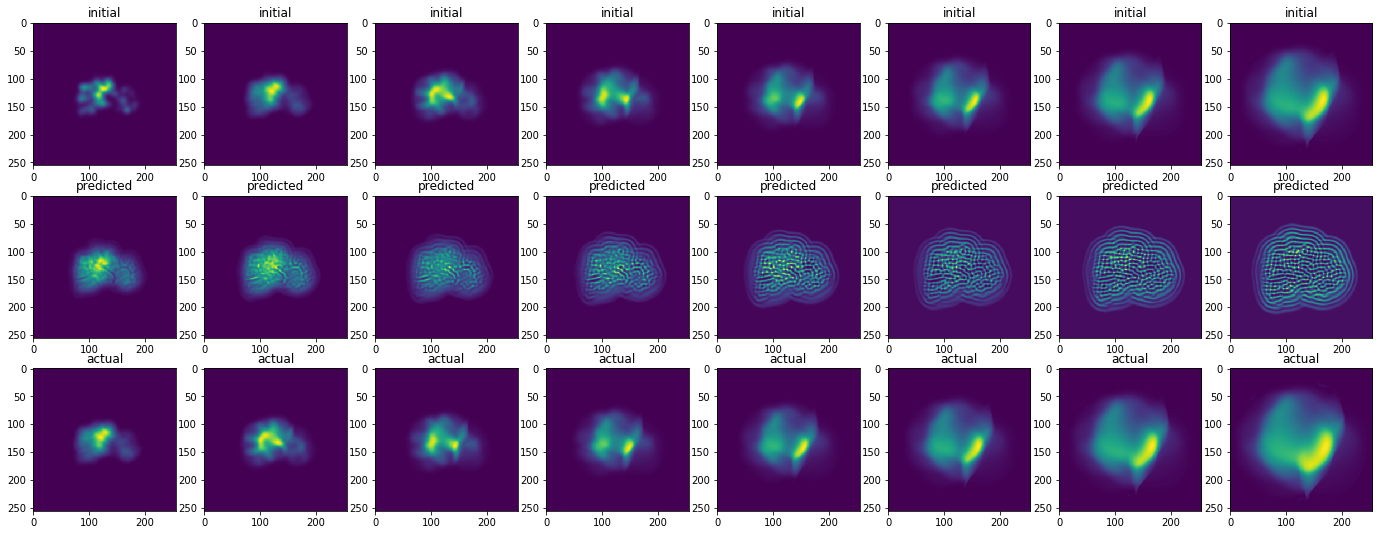

In [7]:
from torch.utils.data.sampler import Sampler
class SubsetSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

count = 8
evo_length = 8
indices = np.arange(len(dataset))
sampler = SubsetSampler(indices)
loader = torch.utils.data.DataLoader(dataset,
                                     sampler=sampler)


fig = plt.figure(figsize=(evo_length * 3, 9))
model.eval()

t, _ = next(iter(loader))
t = t.to(device)
for counter, (x, y) in enumerate(loader):
    if counter >= 8:
        break
        
    prediction_gpu = model(prediction_gpu)
    prediction = prediction_gpu.cpu().detach()
    fig.add_subplot(3, 8, counter + 1)
    plt.title("initial")
    plt.imshow(torch.squeeze(x))
    fig.add_subplot(3, 8, counter + 8 + 1)
    plt.title("predicted")
    plt.imshow(torch.squeeze(prediction))
    fig.add_subplot(3, 8, counter + 16 + 1)
    plt.title("actual")
    plt.imshow(torch.squeeze(y))
    del prediction_gpu
    prediction_gpu = prediction.to(device)


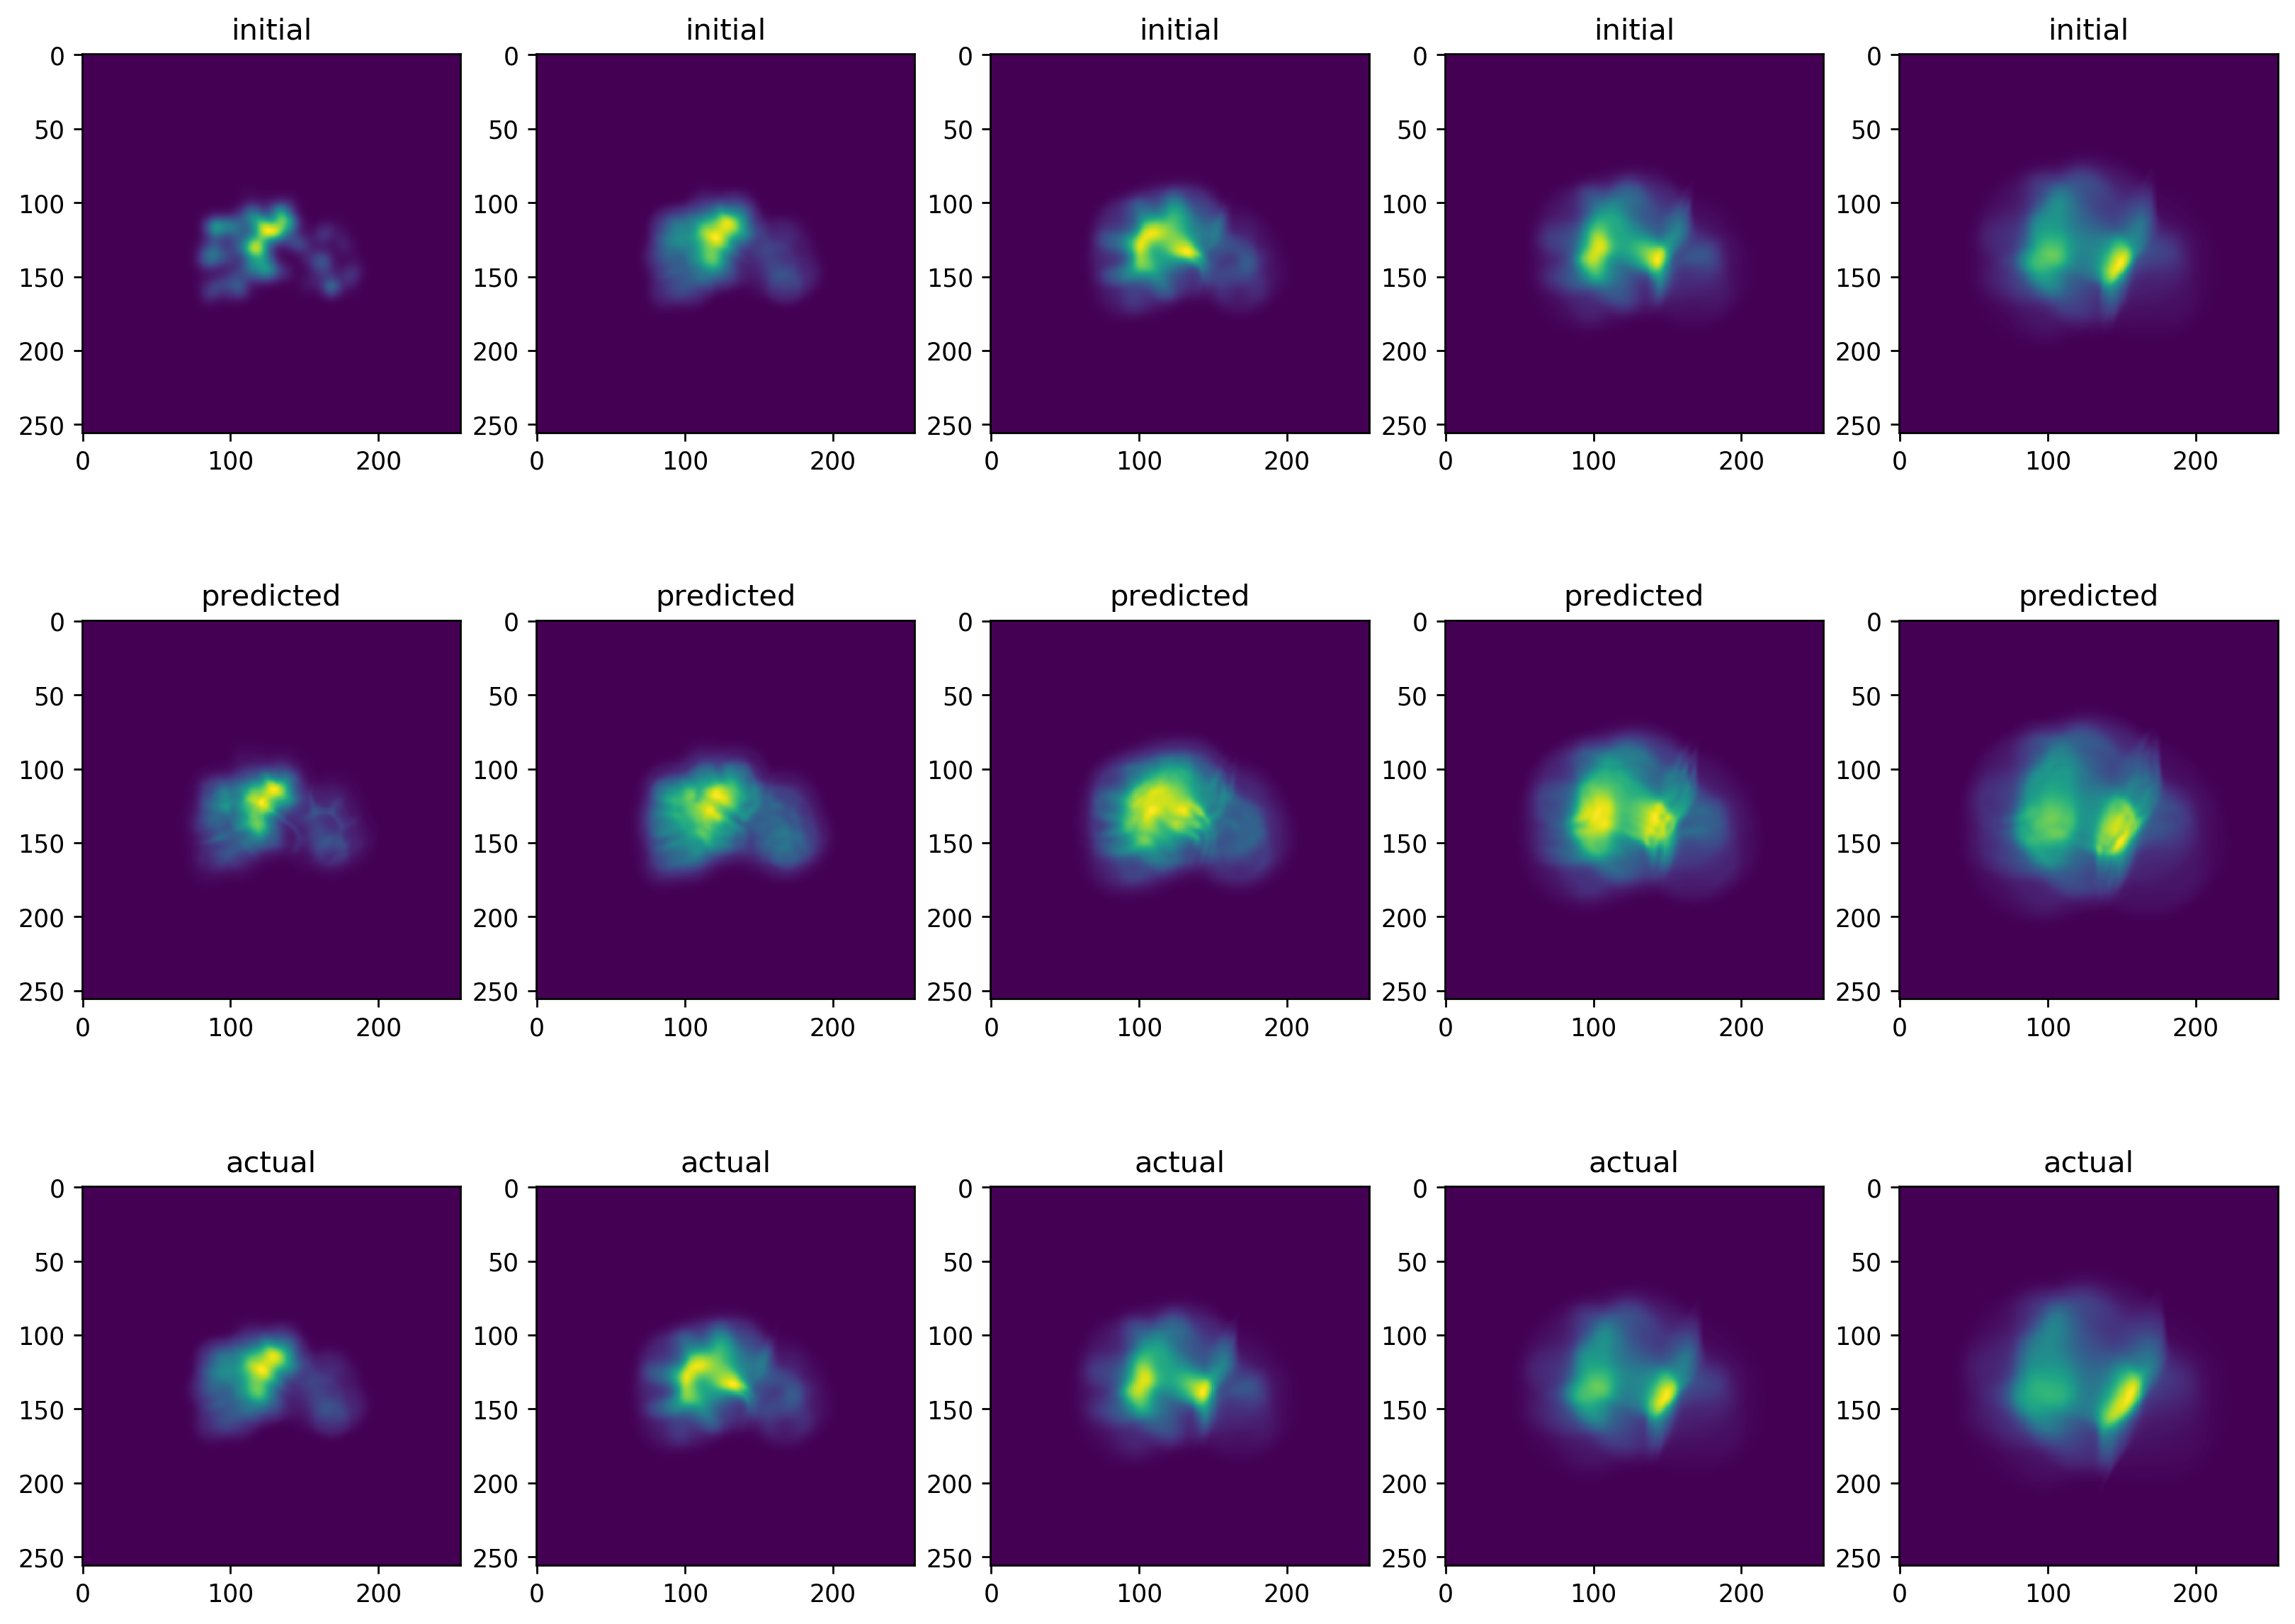

In [8]:
from visualisation import visualise_single_step_prediction
visualise_single_step_prediction(model, dataset)